# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip install imageio
!pip install progressbar

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import pylab as plt
import time
import torch
import os

In [3]:
import progressbar as pb

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [4]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
agents_number = num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_dim = action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_dim = state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
import time
for i in range(1, 3):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        time.sleep(0.1)
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = [-0.1, 0.0, 0.1, 1.00]
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0


When finished, you can close the environment.

env.close()

### Here's my result

In [8]:
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


os.makedirs("./model_results", exist_ok=True)

In [9]:
def moving_average(a, n=100) :
    ret = np.cumsum(np.concatenate([np.zeros(n), a]), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    n_arr = np.clip(np.arange(1, len(a)+1), 1, n)
    return ret[n:] / n_arr

In [10]:
def noise_injection(r, r0=0.05, n_max=1., n_min=0.01):
    if r == 0: return n_max
    return np.clip(r0/r, n_min, n_max)

In [11]:
class Task:
    def __init__(self, env, brain_name):
        self.env = env
        self.brain_name = brain_name
        self.reset()
        
        uniform = torch.distributions.Uniform(-1, 1)
        uniform._batch_shape = torch.Size([1, env.brains[brain_name].vector_action_space_size])
        
        self.action_space = uniform
        
    def reset(self, train_mode=True):
        out = self.env.reset(train_mode=train_mode)[brain_name]     # reset the environment
        return out.vector_observations.astype(np.float32)
    
    def step(self, action):
        out = env.step(action)[self.brain_name]
        state = out.vector_observations.astype(np.float32)
        rewards = out.rewards
        done = out.local_done
        info = out.text_observations
        return (state, rewards, done, info)

In [12]:
task = Task(env, brain_name)
device = torch.device('cuda')

In [13]:
from maddpg import MADDPG
from torch.utils.tensorboard import SummaryWriter

In [23]:
writer = SummaryWriter('runs/p3_maddpg_003')

number_of_episodes = 5000
max_episode_length = 200

noise = 1.0
noise_max, noise_min = 1, 0.5
noise_reduction = 0.99999
noise_reset_episodes = 1000

episode_score_every = 50
save_interval = 200

config = {'batch_size': 128,
          'buffer_size': int(1e5),
          'number_updates': 3,
          'update_every_iterations': 1,
          'critic_lr': 2e-4,
          'actor_lr': 1e-4,
          'actor_lr_decay': 0, #1e-4,
          'critic_lr_decay': 0, #1e-5,
          'actor_tau': 0.001,
          'critic_tau': 0.001,
          'warm_up': 50, # ~40 episodes
          'hidden_layers': (400, 300),
          'noise_scale': 1.,
          'noise_sigma': .4,
          'agents_number': agents_number,
          'gradient_clip': 1.0,
          'discount': 0.99,
         }

maddpg = MADDPG(task, state_dim, action_dim, config, device, writer)
maddpg.reset()

all_rewards = np.zeros((number_of_episodes, agents_number))

In [24]:
print(maddpg.maddpg_agent[0].actor)
print(maddpg.maddpg_agent[0].critic)

ActorBody(
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=2, bias=True)
  )
)
CriticBody(
  (layers): ModuleList(
    (0): Linear(in_features=48, out_features=400, bias=True)
    (1): Linear(in_features=404, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=1, bias=True)
  )
)


In [ ]:
%%time
widget = ['episode: ', pb.Counter(),'/',str(number_of_episodes),' ', 
          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]

timer = pb.ProgressBar(widgets=widget, maxval=number_of_episodes).start()


for episode in range(number_of_episodes):
    timer.update(episode)
    
    state = task.reset().flatten()
    episode_reward = np.zeros(num_agents, dtype=np.float32)

    for frame_idx in range(max_episode_length):

        actions = maddpg.act(state, noise=noise)
        actions = actions.detach().cpu().numpy().astype(np.float32).flatten()

        # step forward one frame
        next_state, rewards, dones, info = task.step(actions)
        #rewards = [r*10 for r in rewards]
        
        episode_reward += rewards        
        next_state = next_state.flatten()
        maddpg.step(state, actions, list(rewards), next_state, dones)

        
        state = next_state.copy()
        
        if any(dones):
            break

    all_rewards[episode] = episode_reward
    _r = all_rewards[max(episode-100, 0):episode]
    writer.add_scalars('rewards/agent0', {'current': episode_reward[0], "avg100": _r[:, 0].mean()}, episode)
    writer.add_scalars('rewards/agent1', {'current': episode_reward[1], 'avg100': _r[:, 1].mean()}, episode)
    
    #noise = noise_injection(_r.max(axis=1).mean(), r0=max(0, 0.02-0.001*(episode/1000)), n_max=noise_max, n_min=noise_min)
    noise = max(noise*noise_reduction, noise_min)
    
    if (episode % episode_score_every) == (episode_score_every-1) or episode == number_of_episodes-1:
        print(f'Ep {episode:4}. Rewards (over last 100): Avg: {np.max(_r, axis=1).mean():<7.3} | Max: {np.max(_r):<4.2} | Min: {np.min(_r):4.2} | Noise: {noise:6.3}')
        
    if episode > 400 and (episode % 50 == 0) and np.max(all_rewards[episode-200:episode+1],axis=1).sum() <= 0.01:
        print("This is pointless. Breaking.")
        break

    #saving model
    if (episode % save_interval == 0) or all_rewards[-10:].max() > 0.5:
        save_dict_list = []
        for agent_i in range(agents_number):
            save_dict = {
                'actor_params' : maddpg.maddpg_agent[agent_i].actor.state_dict(),
                'actor_optim_params': maddpg.maddpg_agent[agent_i].actor_optimizer.state_dict(),
                'critic_params' : maddpg.maddpg_agent[agent_i].critic.state_dict(),
                'critic_optim_params' : maddpg.maddpg_agent[agent_i].critic_optimizer.state_dict()
            }
            save_dict_list.append(save_dict)

        torch.save(save_dict_list, f"./model_results/episode-{episode}.pt")
        
        if all_rewards[-10:].max() > 0.5:
            print("Obtained the required value")
            break

timer.finish()

plt.figure(figsize=(12,8))
all_rewards_total = np.sum(all_rewards, axis=1)
plt.plot(all_rewards[:episode], '--', alpha=0.5)
plt.plot(all_rewards_total[:episode], alpha=0.5)
plt.plot(moving_average(all_rewards_total[:episode], 20), label='20')
plt.plot(moving_average(all_rewards_total[:episode]), label='100')
plt.legend()

<timed exec>:34: RuntimeWarning: Mean of empty slice.                        | 
/home/kretyn/courses/DeRL/venv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<timed exec>:35: RuntimeWarning: Mean of empty slice.


Ep   49. Rewards (over last 100): Avg: 0.0118  | Max: 0.1  | Min: -0.02 | Noise:    1.0


Ep   99. Rewards (over last 100): Avg: 0.0177  | Max: 0.2  | Min: -0.02 | Noise:  0.999


Ep  149. Rewards (over last 100): Avg: 0.0177  | Max: 0.2  | Min: -0.02 | Noise:  0.999


Ep  199. Rewards (over last 100): Avg: 0.0097  | Max: 0.1  | Min: -0.02 | Noise:  0.998


Ep  249. Rewards (over last 100): Avg: 0.0096  | Max: 0.1  | Min: -0.01 | Noise:  0.998


Ep  299. Rewards (over last 100): Avg: 0.0125  | Max: 0.1  | Min: -0.01 | Noise:  0.997


Text(0.5, 0.98, 'Total num actions 1992')

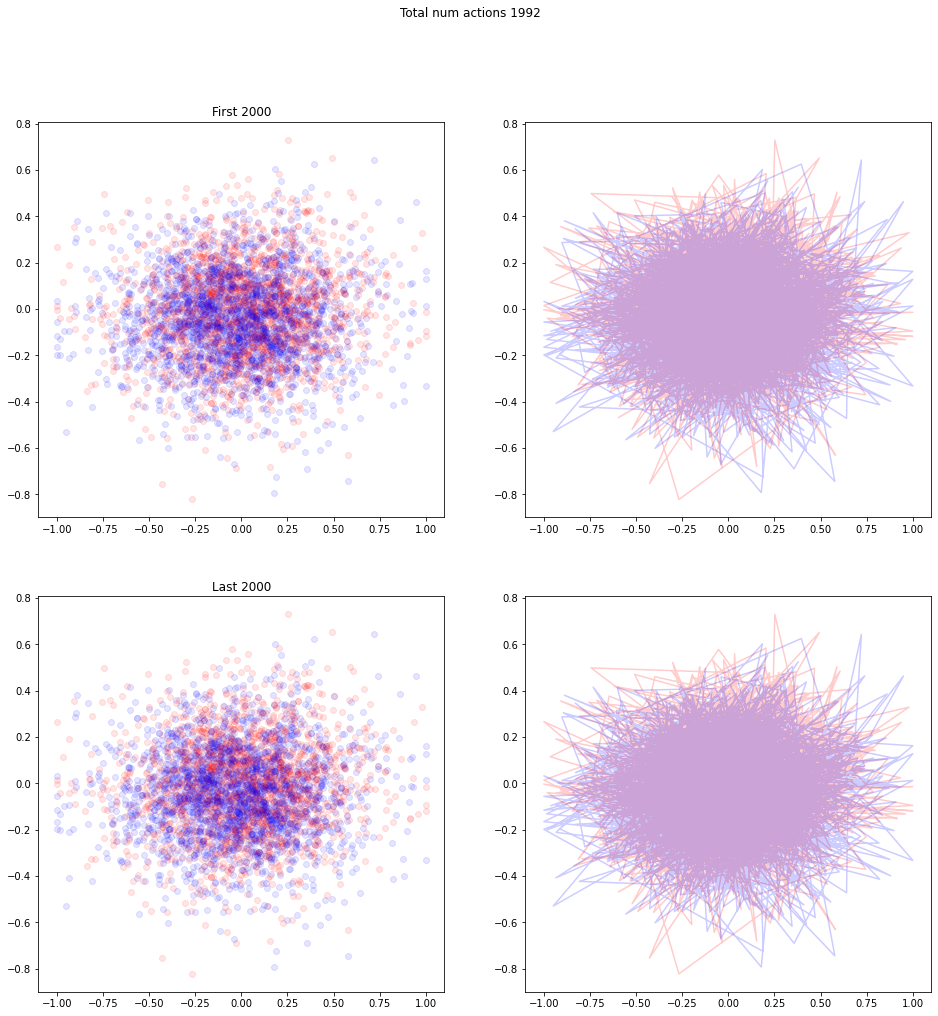

In [21]:
samples = maddpg.buffer.memory
all_actions = np.array([s[1] for s in samples])


fig, axes = plt.subplots(2,2, figsize=(16, 16))

actions = all_actions[:2000]
x1, y1 = actions[:, :2].reshape(2, -1)  # Red actions: right/left, jump
x2, y2 = actions[:, 2:].reshape(2, -1)  # Blue actions: left/right, jump

ax = axes[0][0]
ax.scatter(-x1, y1, color='r', alpha=0.1)
ax.scatter(x2, y2, color='b', alpha=0.1)
ax.set_title("First 2000")

ax = axes[0][1]
ax.plot(-x1, y1, color='r', alpha=0.2)
ax.plot(x2, y2, color='b', alpha=0.2)

actions = all_actions[-2000:]
x1, y1 = actions[:, :2].reshape(2, -1)  # Red actions: right/left, jump
x2, y2 = actions[:, 2:].reshape(2, -1)  # Blue actions: left/right, jump
ax = axes[1][0]
ax.scatter(-x1, y1, color='r', alpha=0.1)
ax.scatter(x2, y2, color='b', alpha=0.1)
ax.set_title("Last 2000")

ax = axes[1][1]
ax.plot(-x1, y1, color='r', alpha=0.2)
ax.plot(x2, y2, color='b', alpha=0.2)


plt.suptitle(f"Total num actions {len(all_actions)}")

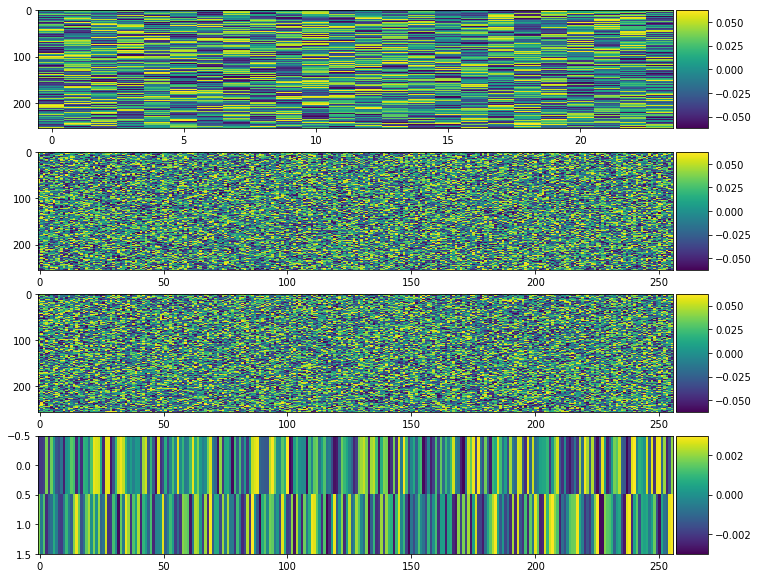

In [22]:
layers = maddpg.maddpg_agent[0].actor.layers
fig, axes = plt.subplots(len(layers), 1, figsize=(12,10))
for idx, layer in enumerate(layers):
    ax = axes[idx]
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(layer.weight.detach().cpu().numpy(), aspect='auto', interpolation='none')

    fig.colorbar(im, cax=cax, orientation='vertical')

# Debug

In [24]:
from torch.utils.tensorboard import SummaryWriter

In [26]:
writer = SummaryWriter()

# Development is here

In [55]:
import torch.nn.functional as F

In [114]:
device = torch.device('cuda')
agent_number = agent_no = 0

In [156]:
self = maddpg

In [159]:
samples = maddpg.filter_batch(maddpg.buffer.sample(), agent_number)
print(f"agent_states: {samples[0].shape}")
print(f"state: {samples[1].shape}")
print(f"actions: {samples[2].shape}")
print(f"rewards: {samples[3].shape}")
print(f"agent_next_states: {samples[4].shape}")
print(f"next_states: {samples[5].shape}")
print(f"dones: {samples[6].shape}")

agent_states: torch.Size([256, 24])
state: torch.Size([256, 48])
actions: torch.Size([256, 4])
rewards: torch.Size([256, 1])
agent_next_states: torch.Size([256, 24])
next_states: torch.Size([256, 48])
dones: torch.Size([256, 1])


In [67]:
action_offset = agent_number*self.action_dim
flatten_actions = lambda a: a.view(-1, self.agents_number*self.action_dim)

# No need to flip since there are no paralle agents
agent_states, states, actions, rewards, agent_next_states, next_states, dones = samples

agent = self.maddpg_agent[agent_number]

next_actions = actions.detach().clone()
next_actions.data[:, action_offset:action_offset+self.action_dim] = agent.target_actor(agent_next_states)

# critic loss
Q_target_next = agent.target_critic(next_states, flatten_actions(next_actions))
Q_target = rewards + (self.discount * Q_target_next * (1 - dones))
Q_expected = agent.critic(states, actions)
critic_loss = F.mse_loss(Q_expected, Q_target)

# Minimize the loss
agent.critic_optimizer.zero_grad()
critic_loss.backward()
torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), self.gradient_clip)
agent.critic_optimizer.step()

# Compute actor loss
pred_actions = actions.detach().clone()
pred_actions.data[:, action_offset:action_offset+self.action_dim] = agent.actor(agent_states)

actor_loss = -agent.critic(states, flatten_actions(pred_actions)).mean()
agent.actor_optimizer.zero_grad()
actor_loss.backward()
agent.actor_optimizer.step()

if self.writter:
    self.writter.add_scalar(f'critic_loss_a{agent_number}', critic_loss.item(), self.iteration)
    self.writter.add_scalar(f'actor_loss_a{agent_number}', actor_loss.item(), self.iteration)

self._soft_update(agent.target_actor, agent.actor)
self._soft_update(agent.target_critic, agent.critic)

In [187]:
if torch.isnan(agent_states).any():
    print("Yes")

Yes


In [171]:
states[:10,0]

tensor([-4.1102,  0.0000,  0.0000, -7.6235, -1.5732, -6.8665, -4.4278, -6.2491,
        -5.3110, -6.6437], device='cuda:0')

In [133]:
actor_loss = -agent.critic(states, flatten_actions(pred_actions)).mean()
agent.actor_optimizer.zero_grad()
actor_loss.backward()
agent.actor_optimizer.step()

In [135]:
actor_loss.item()

-0.06335661560297012

In [133]:
x, y = actions.reshape(2, -1)

In [62]:
_tmp = (1- agent_dones)*self.discount*Q_target_next
print(_tmp.shape)

torch.Size([512, 512])


In [47]:
print(f"state.shape: {state.shape}")
print(f"q_input.shape: {q_input.shape}")
print(f"q_input2.shape: {q_input2.shape}")
print(f"action.shape: {action.shape}")

state.shape: torch.Size([128, 2, 24])
q_input.shape: torch.Size([128, 2, 2])
q_input2.shape: torch.Size([128, 2, 26])
action.shape: torch.Size([128, 2, 2])


In [ ]:
states, actions, rewards, next_states, dones = batch

agent = self.maddpg_agent[agent_no]
next_actions = agent.target_actor(next_states)

if agent_no == 0:
    next_actions = torch.cat((next_actions, actions[:,2:]), dim=1)
else:
    next_actions = torch.cat((actions[:,:2], next_actions), dim=1)

# Compute critic loss
Q_expected = agent.critic(states, actions)
Q_target_next = agent.target_critic(next_states, next_actions)
Q_target = rewards + (self.discount * Q_target_next * (1 - dones))
critic_loss = F.mse_loss(Q_expected, Q_target)

# Minimize the loss
agent.critic_optimizer.zero_grad()
critic_loss.backward()
torch.nn.utils.clip_grad_norm_(agent.local_critic.parameters(), 1)
agent.critic_optimizer.step()

# Compute actor loss
actions_pred = agent.actor(states)
if agent_no == 0:
    actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
else:
    actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)

actor_loss = agent.critic(states, actions_pred).mean()
agent.actor_optimizer.zero_grad()
actor_loss.backward()
agent.actor_optimizer.step()


In [ ]:
maddpg.maddpg_agent.act(obs)

In [ ]:
q_input = [ maddpg.maddpg_agent[num].actor(tensor(obs).select(1, num)) if num == agent_number \
           else maddpg.maddpg_agent[num].actor(tensor(obs).select(1, num)).detach()
           for num in range(agents_number) ]


In [ ]:
_q_input = torch.cat(q_input, dim=1).view(-1, agents_number, action_dim)

In [ ]:
tensor(obs).shape; _q_input.shape

In [ ]:
q_input2 = torch.cat((tensor(obs), _q_input), dim=2)

In [ ]:
tensor(obs).shape

In [ ]:
tensor(obs).select(1, 1).shape

In [ ]:
tensor(obs[0])

In [ ]:
def target_act(obs_all_agents, noise=0.0):
    """get target network actions from all the agents in the MADDPG object """
    target_actions = [ddpg_agent.target_act(tensor(obs), noise) for ddpg_agent, obs in zip(maddpg.maddpg_agent, obs_all_agents)]
    return target_actions

In [ ]:
target_actions = maddpg.target_act(next_obs)

In [ ]:
print(f"obs:  {len(obs)}  |  {obs[0].shape}  |  {type(obs[0])}")
print(f"next_obs:  {len(next_obs)}  |  {next_obs[0].shape}  |  {type(next_obs[0])}")

In [ ]:
from torch import tensor

In [ ]:
target_actions = maddpg.target_act(next_obs[0])

In [ ]:
target_actions

In [ ]:
torch.cat((torch.tensor(obs), target_actions), dim=1)